In [6]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/kaggle")

Mounted at /content/drive


# Import libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
from tqdm import tqdm
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
print(device)

cpu


# Load Data

In [8]:
train_dir = "data/modia/train/train"
test_dir = "data/modia/test/test"
train_images = glob.glob(train_dir+"/**.jpg")
test_images = glob.glob(test_dir+"/**.jpg")

In [9]:
train_images[:5]

['data/modia/train/train/3779.jpg',
 'data/modia/train/train/3545.jpg',
 'data/modia/train/train/576.jpg',
 'data/modia/train/train/3387.jpg',
 'data/modia/train/train/597.jpg']

In [10]:
df_train = pd.read_csv("data/modia/train.csv")
df_train.head()

,id,label
0,0,4
1,1,1
2,2,4
3,3,1
4,4,4


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      4000 non-null   int64
 1   label   4000 non-null   int64
dtypes: int64(2)
memory usage: 62.6 KB


## Show image

In [12]:
def show_image(image_paths):
    fig, axes = plt.subplots(2, 2, figsize = (5,5))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

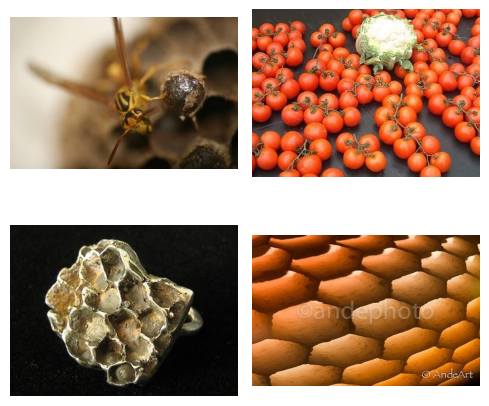

In [13]:
train_list = train_images[:4]
show_image(train_list)

## Transform Data

In [14]:
def train_transform():
    return transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees = 15),
        transforms.RandomResizedCrop(224),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

def val_transform():
    return transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

In [15]:
ID = df_train.pop("id")

# df_train[df_train.index == 0].label


df_train.head()
# df_train_onehot = pd.get_dummies(df_train, columns = ["label"], dtype = int)
# df_train_onehot.head()

# df_train_onehot[df_train_onehot.index == int(train_images[0].split("/")[-1]
#                                                       .split(".")[0])].values

,label
0,4
1,1
2,4
3,1
4,4


## Create class Dataset and DataLoader

In [16]:
class ModiaDataset(Dataset):
    def __init__(self, images, csv_file,mode = "train" ,transform = None):
        self.images = images
        self.labels = pd.read_csv(csv_file)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        if self.mode == "train" or self.mode == "val":
            img = Image.open(image_name)
            label = self.labels[self.labels.index == int(image_name.split("/")[-1].split(".")[0])]["label"].values
            label = torch.tensor(label, dtype = torch.long)
            img = self.transform(img)
            return img, label - 1

        elif self.mode == "test":
            img = Image.open(image_name)
            img = self.transform(img)
            return img, image_name

In [17]:
csv_path = "data/modia/train.csv"

# def train_test_split(X, test_size):
#     test_split_size = int(len(X) *test_size)
#     train_split_size = len(X) - test_split_size
#     np.random.shuffle(X)
#     X_train = X[:train_split_size]
#     X_val = X[train_split_size:]
#     return X_train, X_val
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_images, test_size = 0.2, random_state = 0)

train_dataset = ModiaDataset(X_train, csv_path, mode = "train", transform = train_transform())
val_dataset = ModiaDataset(X_val, csv_path, mode = "val", transform = val_transform())
test_dataset = ModiaDataset(test_images, csv_path, mode = "test", transform = val_transform())

train_data_loader = DataLoader(train_dataset, batch_size = 32,
                               shuffle = True, num_workers = 2)

val_data_loader = DataLoader(val_dataset, batch_size = 32,
                             shuffle = True, num_workers = 2)

test_data_loader = DataLoader(test_dataset, batch_size = 1,
                              shuffle = False, num_workers = 2)


In [ ]:
# train_iter = iter(train_data_loader)
# images, labels = next(train_iter)
# # print(labels.T)
# print(labels)
# labels.shape

# Train, valid and run model per epoch

In [18]:
def accuracy(pred, label):
    # Lấy nhãn dự đoán bằng cách tìm giá trị lớn nhất theo chiều 1
    pred = torch.argmax(pred, dim=1)
    # So sánh nhãn dự đoán với nhãn thực tế
    correct = (pred == label).sum().item()
    # Tính độ chính xác
    acc = correct / len(label) * 100
    return acc

In [19]:
def train_one_epoch(model, data_loader, optimizer, loss_criteria, history_train):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    model.train()

    for batch_idx, (images, labels) in tqdm(enumerate(data_loader)):
        images = images.to(device)
        labels = labels.flatten().to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss = loss_criteria(pred, labels)
        epoch_loss.append(loss.item())


        acc = accuracy(pred, labels)
        epoch_acc.append(acc)


        # if batch_idx % 100 == 0 and batch_idx != 0:
        #     print(f"\nLoss at batch {batch_idx}: {torch.mean(torch.tensor(epoch_loss, dtype = torch.float32))}")
        #     print(f"Accuracy at batch {batch_idx}: {torch.mean(torch.tensor(epoch_acc, dtype = torch.float32))}\n")

        loss.backward()
        optimizer.step()

    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = torch.mean(torch.tensor(epoch_loss, dtype = torch.float32))
    epoch_acc = torch.mean(torch.tensor(epoch_acc, dtype = torch.float32))

    history_train["loss"].append(epoch_loss)
    history_train["acc"].append(epoch_acc)
    history_train["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time

def test_one_epoch(model, data_loader, loss_criteria, history_test,
                   model_name, best_val_acc):
    epoch_loss = []
    epoch_acc = []

    start_time = time.time()
    model.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in tqdm(enumerate(data_loader)):
            images = images.to(device)
            labels = labels.flatten().to(device)

            pred = model(images)

            loss = loss_criteria(pred, labels)
            epoch_loss.append(loss.item())

            acc = accuracy(pred, labels)
            epoch_acc.append(acc)

            # if batch_idx % 100 == 0 and batch_idx != 0:
            #     print(f"\nLoss at batch {batch_idx}: {torch.mean(torch.tensor(epoch_loss, dtype = torch.float32))}")
            #     print(f"Accuracy at batch {batch_idx}: {torch.mean(torch.tensor(epoch_acc, dtype = torch.float32))}\n")

        end_time = time.time()
        total_time = end_time - start_time

        epoch_loss = torch.mean(torch.tensor(epoch_loss, dtype = torch.float32))
        epoch_acc = torch.mean(torch.tensor(epoch_acc, dtype = torch.float32))

        history_test["loss"].append(epoch_loss)
        history_test["acc"].append(epoch_acc)
        history_test["time"].append(total_time)

        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), f"{model_name}.pth")

    return epoch_loss, epoch_acc, total_time

def run_model(model, train_loader, val_loader, loss_criteria, optimizer,
              history_train, history_test ,best_val_acc, model_name, num_epochs):
    optimizer.zero_grad()
    for epoch in range(num_epochs):

        print("\nTraining........")
        train_loss, train_acc, train_time = train_one_epoch(model,
                                                            train_loader,
                                                            optimizer,
                                                            loss_criteria,
                                                            history_train)
        print(f"\nEpoch {epoch + 1}")
        print(f"Train Loss: {train_loss}")
        print(f"Train Accuracy: {train_acc}")
        print(f"Train Time: {train_time}")


        print("\nValidating........")
        val_loss, val_acc, val_time = test_one_epoch(model, val_loader,
                                                     loss_criteria,
                                                     history_test,
                                                     "my_model",
                                                     best_val_acc)
        print(f"\nEpoch {epoch + 1}")
        print(f"Val Loss: {val_loss}")
        print(f"Val Accuracy: {val_acc}")
        print(f"Val Time: {val_time}")

# Method 1: Self Create Model, check and hyperparameter it

In [43]:
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size = 7, stride = 2, padding = 0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 5, stride = 2, padding = 0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(2048, 1000)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(1000, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.softmax(out)

        return out

In [15]:
from torchsummary import summary

model=CNNnet()
model.to(device)
summary(model, (3, 224, 224), device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 109, 109]          18,944
       BatchNorm2d-2        [-1, 128, 109, 109]             256
              ReLU-3        [-1, 128, 109, 109]               0
         MaxPool2d-4          [-1, 128, 54, 54]               0
            Conv2d-5          [-1, 256, 25, 25]         819,456
       BatchNorm2d-6          [-1, 256, 25, 25]             512
              ReLU-7          [-1, 256, 25, 25]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9            [-1, 512, 5, 5]       1,180,160
      BatchNorm2d-10            [-1, 512, 5, 5]           1,024
             ReLU-11            [-1, 512, 5, 5]               0
        MaxPool2d-12            [-1, 512, 2, 2]               0
           Linear-13                 [-1, 1000]       2,049,000
             ReLU-14                 [-

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [18]:
best_val_acc = 0

num_epochs = 10

history_train = {"loss": [], "acc": [], "time": []}
history_test = {"loss": [], "acc": [], "time": []}

loss_criteria = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.33)

run_model(model, train_data_loader, val_data_loader, loss_criteria,
          optimizer, history_train, history_test, best_val_acc,"resnet50", num_epochs)


Training........


0it [00:14, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## Hyper Parameter tuning

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00


In [43]:
from optuna.trial import TrialState
import optuna

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 3, 5)
    layers = []
    act_layers = {
        "relu": nn.ReLU(),
        "sigmoid": nn.Sigmoid(),
        "gelu": nn.GELU()
    }

    in_chan = trial.suggest_int("depth", 20, 100)
    pre_kernel_size = 7
    x = torch.randn(2, 3 ,224, 224)
    first_layer = True
    w = 224
    for i in range(n_layers):
        scale_chan = trial.suggest_float("scale", 1.1, 2.5)
        out_chan = int(in_chan*scale_chan)
        scale_kernel_size = trial.suggest_float("scale_kernel_size", 1, 2)
        kernel_size = 2 * int((pre_kernel_size - 1)/(2*scale_kernel_size))+1
        stride = trial.suggest_int("stride", 1, 2)
        act_type = trial.suggest_categorical("act_type", ["relu", "sigmoid", "gelu"])
        p = trial.suggest_float("dropout", 0, 0.2)
        if first_layer:
            kernel_size = pre_kernel_size
            in_chan = 3
        if w >= 2:
            layer = nn.Sequential(
                nn.Conv2d(in_chan, out_chan, kernel_size = kernel_size, stride = stride, padding = 0),
                nn.BatchNorm2d(out_chan),
                act_layers[act_type],
                nn.MaxPool2d(2),
                nn.Dropout(p)
            )

            layers.append(layer)
            first_layer = False
            in_chan = out_chan
            pre_kernel_size = kernel_size
            x = layer(x)
            dim = x.shape
            w = dim[3]
    in_features = dim[1] * dim[2] * dim[3]
    layers.append(nn.Flatten())
    layers.append(nn.Linear(in_features, 1000))
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(1000, 4))
    layers.append(nn.ReLU())
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

epoch = 10
def objective(trial):

    model = define_model(trial)
    model.to(device)
    optimizations = {
        "Adam": optim.Adam,
        "SGD": optim.SGD,
        "RMSprop": optim.RMSprop
    }
    criteria = {
        "CrossEntropyLoss": nn.CrossEntropyLoss(),
        "HuberLoss": nn.HuberLoss(),
    }

    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "SGD", "RMSprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log = True)


    optimizer = optimizations[optimizer_name](model.parameters(), lr = learning_rate)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.33)

    # Loss
    loss_name = trial.suggest_categorical("loss_name", ["CrossEntropyLoss", "HuberLoss"])

    loss_criteria = criteria[loss_name]

    best_val_acc = 0

    history_train = {"loss": [], "acc": [], "time": []}
    history_test = {"loss": [], "acc": [], "time": []}

    run_model(model, train_data_loader, val_data_loader, loss_criteria,
          optimizer, history_train, history_test, best_val_acc, epoch)


ModuleNotFoundError: No module named 'optuna'

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

[I 2024-07-12 09:14:38,205] A new study created in memory with name: no-name-701e17c6-b73f-4d69-ac89-70257901b44e



Training........


100it [00:35,  2.84it/s]



Epoch 1
Train Loss: 1.3293098211288452
Train Accuracy: 46.3125
Train Time: 35.22086024284363

Validating........


50it [00:04, 10.68it/s]



Epoch 1
Val Loss: 1.2826343774795532
Val Accuracy: 57.875
Val Time: 4.7651283740997314

Training........


100it [00:26,  3.74it/s]



Epoch 2
Train Loss: 1.2842730283737183
Train Accuracy: 56.0
Train Time: 26.809627771377563

Validating........


50it [00:04, 11.64it/s]



Epoch 2
Val Loss: 1.2584004402160645
Val Accuracy: 60.25
Val Time: 4.348269462585449

Training........


100it [00:26,  3.80it/s]



Epoch 3
Train Loss: 1.2656620740890503
Train Accuracy: 58.4375
Train Time: 26.3627507686615

Validating........


50it [00:04, 10.48it/s]



Epoch 3
Val Loss: 1.2480926513671875
Val Accuracy: 59.875
Val Time: 4.8281848430633545

Training........


100it [00:28,  3.56it/s]



Epoch 4
Train Loss: 1.2566930055618286
Train Accuracy: 58.1875
Train Time: 28.17870330810547

Validating........


50it [00:04, 11.61it/s]



Epoch 4
Val Loss: 1.237244963645935
Val Accuracy: 62.625
Val Time: 4.366897821426392

Training........


100it [00:26,  3.76it/s]



Epoch 5
Train Loss: 1.2526030540466309
Train Accuracy: 58.40625
Train Time: 26.66836905479431

Validating........


50it [00:05,  8.72it/s]



Epoch 5
Val Loss: 1.2346775531768799
Val Accuracy: 62.625
Val Time: 5.8017401695251465

Training........


100it [00:26,  3.79it/s]


Epoch 6
Train Loss: 1.2479981184005737
Train Accuracy: 59.28125
Train Time: 26.474135160446167

Validating........



50it [00:04, 11.01it/s]



Epoch 6
Val Loss: 1.2329767942428589
Val Accuracy: 62.25
Val Time: 4.6292054653167725

Training........


100it [00:29,  3.39it/s]



Epoch 7
Train Loss: 1.2455366849899292
Train Accuracy: 59.40625
Train Time: 29.539602041244507

Validating........


50it [00:05,  9.68it/s]



Epoch 7
Val Loss: 1.2277370691299438
Val Accuracy: 64.0
Val Time: 5.225996494293213

Training........


100it [00:26,  3.74it/s]


Epoch 8
Train Loss: 1.2429717779159546
Train Accuracy: 59.46875
Train Time: 26.78421711921692

Validating........



50it [00:04, 11.13it/s]



Epoch 8
Val Loss: 1.2255080938339233
Val Accuracy: 62.5
Val Time: 4.594800233840942

Training........


100it [00:26,  3.77it/s]



Epoch 9
Train Loss: 1.238702654838562
Train Accuracy: 60.65625
Train Time: 26.582894802093506

Validating........


50it [00:04, 11.49it/s]



Epoch 9
Val Loss: 1.2223854064941406
Val Accuracy: 63.625
Val Time: 4.418856620788574

Training........


100it [00:32,  3.10it/s]



Epoch 10
Train Loss: 1.239207148551941
Train Accuracy: 60.0625
Train Time: 32.372583866119385

Validating........


50it [00:04, 11.05it/s]
[W 2024-07-12 09:21:00,795] Trial 0 failed with parameters: {'n_layers': 3, 'depth': 25, 'scale': 2.2143241244525527, 'scale_kernel_size': 1.5617528831107717, 'stride': 1, 'act_type': 'relu', 'dropout': 0.006507522201893346, 'optimizer_name': 'SGD', 'learning_rate': 0.00024525987591294125, 'loss_name': 'CrossEntropyLoss'} because of the following error: The value None could not be cast to float..
[W 2024-07-12 09:21:00,800] Trial 0 failed with value None.



Epoch 10
Val Loss: 1.2180986404418945
Val Accuracy: 65.0
Val Time: 4.587956666946411


[W 2024-07-12 09:21:01,008] Trial 1 failed with parameters: {'n_layers': 4, 'depth': 62, 'scale': 1.3096450218321989, 'scale_kernel_size': 1.1377688352327793, 'stride': 2, 'act_type': 'gelu', 'dropout': 0.06212778194262361} because of the following error: RuntimeError('Given input size: (180x1x1). Calculated output size: (180x0x0). Output size is too small').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-19-2859f18bfd25>", line 57, in objective
    model = define_model(trial)
  File "<ipython-input-19-2859f18bfd25>", line 42, in define_model
    x = layer(x)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **

RuntimeError: Given input size: (180x1x1). Calculated output size: (180x0x0). Output size is too small

# Method 2: Use Pre-trained model

In [30]:
from torchvision import models
model = models.efficientnet_b2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(num_features, 1000, bias = True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1000, 4, bias = True),
)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 70.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [70]:
model.to(device)

best_val_acc = 0

epoch = 30

history_train = {"loss": [], "acc": [], "time": []}
history_test = {"loss": [], "acc": [], "time": []}

loss_criteria = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

run_model(model, train_data_loader, val_data_loader, loss_criteria,
          optimizer, history_train, history_test, best_val_acc,"efficient", epoch)


Training........


100it [00:43,  2.32it/s]


Epoch 1
Train Loss: 0.34002554416656494
Train Accuracy: 87.5
Train Time: 43.27756309509277

Validating........



25it [00:04,  5.73it/s]



Epoch 1
Val Loss: 0.08843861520290375
Val Accuracy: 97.375
Val Time: 4.448240518569946

Training........


100it [00:43,  2.29it/s]


Epoch 2
Train Loss: 0.30419719219207764
Train Accuracy: 88.96875
Train Time: 43.79468297958374

Validating........



25it [00:05,  4.91it/s]



Epoch 2
Val Loss: 0.09702145308256149
Val Accuracy: 97.25
Val Time: 5.1816301345825195

Training........


100it [00:43,  2.32it/s]


Epoch 3
Train Loss: 0.26486510038375854
Train Accuracy: 89.90625
Train Time: 43.243536949157715

Validating........



25it [00:06,  3.86it/s]



Epoch 3
Val Loss: 0.08366155624389648
Val Accuracy: 97.5
Val Time: 6.592865228652954

Training........


100it [00:40,  2.46it/s]


Epoch 4
Train Loss: 0.28199756145477295
Train Accuracy: 90.03125
Train Time: 40.78697490692139

Validating........



25it [00:06,  3.85it/s]



Epoch 4
Val Loss: 0.08033005893230438
Val Accuracy: 97.375
Val Time: 6.569774150848389

Training........


100it [00:40,  2.45it/s]


Epoch 5
Train Loss: 0.24766923487186432
Train Accuracy: 90.9375
Train Time: 40.91397023200989

Validating........



25it [00:06,  3.98it/s]



Epoch 5
Val Loss: 0.08327491581439972
Val Accuracy: 97.25
Val Time: 6.375880002975464

Training........


100it [00:41,  2.39it/s]



Epoch 6
Train Loss: 0.24218089878559113
Train Accuracy: 90.84375
Train Time: 42.00039982795715

Validating........


25it [00:05,  4.96it/s]



Epoch 6
Val Loss: 0.10065395385026932
Val Accuracy: 96.875
Val Time: 5.1274120807647705

Training........


100it [00:42,  2.37it/s]


Epoch 7
Train Loss: 0.24599309265613556
Train Accuracy: 90.46875
Train Time: 42.285900592803955

Validating........



25it [00:04,  5.38it/s]



Epoch 7
Val Loss: 0.09957583248615265
Val Accuracy: 96.375
Val Time: 4.759862899780273

Training........


100it [00:42,  2.34it/s]


Epoch 8
Train Loss: 0.23026734590530396
Train Accuracy: 91.65625
Train Time: 42.810054302215576

Validating........



25it [00:04,  5.56it/s]



Epoch 8
Val Loss: 0.07429260015487671
Val Accuracy: 97.375
Val Time: 4.578070878982544

Training........


100it [00:42,  2.37it/s]


Epoch 9
Train Loss: 0.228412926197052
Train Accuracy: 91.84375
Train Time: 42.332520723342896

Validating........



25it [00:04,  5.60it/s]



Epoch 9
Val Loss: 0.08018098771572113
Val Accuracy: 97.5
Val Time: 4.568779945373535

Training........


100it [00:41,  2.38it/s]


Epoch 10
Train Loss: 0.2357223480939865
Train Accuracy: 91.125
Train Time: 42.072298526763916

Validating........



25it [00:04,  5.58it/s]



Epoch 10
Val Loss: 0.07544665038585663
Val Accuracy: 97.375
Val Time: 4.563035249710083

Training........


100it [00:42,  2.37it/s]


Epoch 11
Train Loss: 0.21917635202407837
Train Accuracy: 91.34375
Train Time: 42.237255573272705

Validating........



25it [00:04,  5.75it/s]



Epoch 11
Val Loss: 0.074790820479393
Val Accuracy: 97.75
Val Time: 4.430477857589722

Training........


100it [00:43,  2.31it/s]


Epoch 12
Train Loss: 0.22772957384586334
Train Accuracy: 91.71875
Train Time: 43.3477737903595

Validating........



25it [00:05,  4.28it/s]



Epoch 12
Val Loss: 0.08014950156211853
Val Accuracy: 97.375
Val Time: 5.931278467178345

Training........


100it [00:41,  2.43it/s]


Epoch 13
Train Loss: 0.23094907402992249
Train Accuracy: 91.375
Train Time: 41.2877254486084

Validating........



25it [00:05,  4.28it/s]



Epoch 13
Val Loss: 0.11083316057920456
Val Accuracy: 96.25
Val Time: 5.9644927978515625

Training........


100it [00:41,  2.41it/s]



Epoch 14
Train Loss: 0.22988182306289673
Train Accuracy: 91.375
Train Time: 41.53474426269531

Validating........


25it [00:04,  5.42it/s]



Epoch 14
Val Loss: 0.0828823447227478
Val Accuracy: 97.625
Val Time: 4.732562780380249

Training........


100it [00:42,  2.33it/s]


Epoch 15
Train Loss: 0.19796766340732574
Train Accuracy: 92.84375
Train Time: 43.02164363861084

Validating........



25it [00:04,  5.69it/s]



Epoch 15
Val Loss: 0.09453413635492325
Val Accuracy: 96.875
Val Time: 4.479031085968018

Training........


100it [00:42,  2.37it/s]


Epoch 16
Train Loss: 0.21036039292812347
Train Accuracy: 92.15625
Train Time: 42.38854742050171

Validating........



25it [00:04,  5.68it/s]



Epoch 16
Val Loss: 0.08888740837574005
Val Accuracy: 97.0
Val Time: 4.492608547210693

Training........


100it [00:42,  2.38it/s]


Epoch 17
Train Loss: 0.187362402677536
Train Accuracy: 93.09375
Train Time: 42.16320753097534

Validating........



25it [00:04,  5.64it/s]



Epoch 17
Val Loss: 0.09415283799171448
Val Accuracy: 97.25
Val Time: 4.511898994445801

Training........


100it [00:41,  2.40it/s]


Epoch 18
Train Loss: 0.2210860699415207
Train Accuracy: 92.3125
Train Time: 41.85208868980408

Validating........



25it [00:04,  5.58it/s]



Epoch 18
Val Loss: 0.08849243074655533
Val Accuracy: 97.125
Val Time: 4.567837476730347

Training........


100it [00:42,  2.37it/s]


Epoch 19
Train Loss: 0.200832799077034
Train Accuracy: 92.65625
Train Time: 42.359095335006714

Validating........



25it [00:04,  5.03it/s]



Epoch 19
Val Loss: 0.08621858805418015
Val Accuracy: 97.125
Val Time: 5.062641620635986

Training........


100it [00:41,  2.44it/s]


Epoch 20
Train Loss: 0.21592594683170319
Train Accuracy: 92.09375
Train Time: 41.15398693084717

Validating........



25it [00:05,  4.68it/s]



Epoch 20
Val Loss: 0.08934856206178665
Val Accuracy: 97.25
Val Time: 5.433866024017334

Training........


100it [00:39,  2.53it/s]


Epoch 21
Train Loss: 0.18410047888755798
Train Accuracy: 93.0625
Train Time: 39.63923764228821

Validating........



25it [00:06,  3.83it/s]



Epoch 21
Val Loss: 0.12183205783367157
Val Accuracy: 96.5
Val Time: 6.608523845672607

Training........


100it [00:39,  2.54it/s]


Epoch 22
Train Loss: 0.2164117842912674
Train Accuracy: 91.71875
Train Time: 39.51457333564758

Validating........



25it [00:06,  4.04it/s]



Epoch 22
Val Loss: 0.11701932549476624
Val Accuracy: 96.0
Val Time: 6.2748353481292725

Training........


100it [00:39,  2.51it/s]


Epoch 23
Train Loss: 0.19889497756958008
Train Accuracy: 92.46875
Train Time: 39.90382409095764

Validating........



25it [00:05,  4.21it/s]



Epoch 23
Val Loss: 0.09463013708591461
Val Accuracy: 97.125
Val Time: 6.069288492202759

Training........


100it [00:40,  2.50it/s]


Epoch 24
Train Loss: 0.19473101198673248
Train Accuracy: 92.5625
Train Time: 40.14108371734619

Validating........



25it [00:05,  4.35it/s]



Epoch 24
Val Loss: 0.0891738161444664
Val Accuracy: 97.0
Val Time: 5.848332405090332

Training........


100it [00:41,  2.44it/s]



Epoch 25
Train Loss: 0.18929187953472137
Train Accuracy: 92.75
Train Time: 41.13524627685547

Validating........


25it [00:04,  5.52it/s]



Epoch 25
Val Loss: 0.08584577590227127
Val Accuracy: 97.125
Val Time: 4.659701824188232

Training........


100it [00:42,  2.37it/s]


Epoch 26
Train Loss: 0.19110538065433502
Train Accuracy: 92.96875
Train Time: 42.22578811645508

Validating........



25it [00:04,  5.89it/s]



Epoch 26
Val Loss: 0.09123675525188446
Val Accuracy: 97.375
Val Time: 4.328125

Training........


100it [00:41,  2.40it/s]


Epoch 27
Train Loss: 0.1782265603542328
Train Accuracy: 93.53125
Train Time: 41.80831003189087

Validating........



25it [00:04,  5.65it/s]



Epoch 27
Val Loss: 0.08232828229665756
Val Accuracy: 97.5
Val Time: 4.515134811401367

Training........


100it [00:42,  2.36it/s]


Epoch 28
Train Loss: 0.18217214941978455
Train Accuracy: 92.875
Train Time: 42.557302951812744

Validating........



25it [00:04,  5.72it/s]



Epoch 28
Val Loss: 0.09581694006919861
Val Accuracy: 97.0
Val Time: 4.458382606506348

Training........


100it [00:42,  2.38it/s]


Epoch 29
Train Loss: 0.2128722071647644
Train Accuracy: 92.15625
Train Time: 42.156980991363525

Validating........



25it [00:04,  5.67it/s]



Epoch 29
Val Loss: 0.0771852657198906
Val Accuracy: 97.25
Val Time: 4.494393825531006

Training........


100it [00:41,  2.38it/s]


Epoch 30
Train Loss: 0.1895102709531784
Train Accuracy: 92.9375
Train Time: 42.11519646644592

Validating........



25it [00:04,  5.64it/s]



Epoch 30
Val Loss: 0.1132294088602066
Val Accuracy: 96.125
Val Time: 4.5133702754974365


In [33]:
import torch
model.load_state_dict(torch.load("my_model.pth", map_location=torch.device('cpu')))

# model_load = torch.load("my_model.pth",map_location=torch.device('cpu') )
img_name = []
def predict_image(model,test_data_loader):
    # Đảm bảo rằng mô hình ở chế độ đánh giá
    model.eval()
    ans = []
    with torch.no_grad():
        # Dự đoán
        for img, image_name in test_data_loader:
            pred = model(img)
        # Lấy nhãn với xác suất cao nhất
            pred = torch.argmax(pred, dim=1)
            # So sánh nhãn dự đoán với nhãn thực tế
            ans.append(pred.item())
            img_name.append(image_name)
            # return pred, image_name
    return ans, img_name

# Ví dụ dự đoán cho một hình ảnh
predicted_label, img_name = predict_image(model, test_data_loader)
# print(f"Image: {image_name}, Predicted Label: {predicted_label}")
print(predicted_label)
print(img_name)

[2, 0, 0, 1, 0, 1, 0, 2, 3, 1, 3, 3, 3, 0, 3, 1, 2, 1, 1, 1, 3, 2, 1, 2, 0, 0, 3, 1, 2, 2, 0, 3, 1, 3, 0, 3, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 3, 2, 0, 3, 1, 1, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 1, 1, 0, 2, 1, 3, 1, 0, 1, 3, 3, 2, 3, 3, 2, 1, 0, 3, 3, 2, 0, 3, 0, 2, 2, 2, 1, 1, 1, 2, 1, 3, 0, 0, 2, 0, 0, 3, 0, 2, 1, 3, 0, 1, 0, 1, 3, 1, 2, 3, 1, 3, 0, 3, 2, 3, 2, 2, 3, 3, 1, 3, 3, 0, 1, 3, 3, 2, 3, 0, 0, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 2, 2, 0, 0, 0, 1, 0, 1, 2, 3, 3, 2, 1, 1, 1, 0, 0, 1, 2, 3, 1, 2, 3, 1, 3, 1, 2, 2, 2, 0, 2, 3, 0, 0, 2, 2, 0, 2, 3, 1, 3, 1, 1, 1, 3, 0, 1, 2, 2, 2, 0, 0, 2, 0, 3, 0, 2, 1, 1, 2, 1, 2, 1, 3, 0, 3, 2, 0, 1, 3, 0, 3, 0, 0, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 3, 0, 1, 3, 0, 1, 2, 2, 1, 2, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 2, 1, 1, 3, 3, 0, 2, 1, 3, 2, 0, 0, 1, 3, 2, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 2, 3, 1, 0, 2, 2, 3, 3, 1, 0, 0, 2, 3, 0, 2, 1, 3, 0, 3, 1, 1, 0, 0, 1, 3, 2, 3, 3, 3, 1, 1, 1, 1, 0, 0, 2, 3, 2, 0, 2, 1, 2, 2, 

In [44]:
def image_to_name(img_name):
    image_name = []
    for i in img_name:
        image_name.append(i[0].split("/")[-1].split(".")[0])
    return image_name

In [69]:
id = image_to_name(img_name)
predicted_label = np.asarray(predicted_label) + 1

In [70]:
df = pd.DataFrame({"id": id, "label": predicted_label})


In [71]:
df['id'] = df['id'].astype(int)

In [72]:
df.sort_values(by=['id'], inplace=True)

In [73]:
df.head()

,id,label
1068,4000,1
385,4001,1
603,4002,2
106,4003,1
151,4004,3


In [74]:
df.to_csv("submission.csv", index=False)